# Análisis Exploratorio y clasificación de Daños por Incendios Forestales

## Objetivo
El objetivo de este trabajo es aplicar métodos de Extracción, Tranformación y Limpieza (ETL) y Análisis Exploratorio de Datos (EDA) en un data set de Incendios Forestales en Caligfornia, para evaluar el nivel de daño provocado mediante un modelo de clasificación basado en árboles de decisión a partir de variables ambientales y operativas.



In [ ]:
!kaggle datasets download -d "behroozsohrabi/california-wildfire-incidents-20132020"
#!pip install -U kagglehub

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
#Dataset descargado, descomprimido y cargado en colab
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vijayveersingh/the-california-wildfire-data")

print("Path to dataset files:", path)

100%|██████████| 18.6M/18.6M [00:00<00:00, 81.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vijayveersingh/the-california-wildfire-data/versions/1


In [ ]:
#Enlistamos los archivos que hay en el path
import os
os.listdir(path)

['b8aeb030-140d-43d2-aa29-1a80862e3d62.csv',
 'POSTFIRE_MASTER_DATA_SHARE_140463065990229786.geojson']

## Exploración inicial del conjunto de datos

En esta sección se realiza una inspección preliminar del conjunto de datos,
incluyendo la estructura de las variables, tipos de datos y un resumen
estadístico general. Esto permite identificar posibles problemas de calidad
de datos y definir los pasos de limpieza necesarios.

In [ ]:
#Abrimos el path unido de la carpeta, más el nombre del archivo
df = pd.read_csv(os.path.join(path, 'b8aeb030-140d-43d2-aa29-1a80862e3d62.csv'))

/tmp/ipython-input-2425750110.py:2: DtypeWarning: Columns (13,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(path, 'b8aeb030-140d-43d2-aa29-1a80862e3d62.csv'))


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100230 entries, 0 to 100229
Data columns (total 47 columns):
 #   Column                                                        Non-Null Count   Dtype  
---  ------                                                        --------------   -----  
 0   _id                                                           100230 non-null  int64  
 1   OBJECTID                                                      100230 non-null  int64  
 2   * Damage                                                      100230 non-null  object 
 3   * Street Number                                               95810 non-null   float64
 4   * Street Name                                                 94744 non-null   object 
 5   * Street Type (e.g. road, drive, lane, etc.)                  87033 non-null   object 
 6   Street Suffix (e.g. apt. 23, blding C)                        44148 non-null   object 
 7   * City                                                  

In [ ]:
df.isnull().sum()

,0
_id,0
OBJECTID,0
* Damage,0
* Street Number,4420
* Street Name,5486
"* Street Type (e.g. road, drive, lane, etc.)",13197
"Street Suffix (e.g. apt. 23, blding C)",56082
* City,31614
State,7
Zip Code,52801


## Preparación y limpieza de los datos

Se realizan transformaciones básicas sobre el conjunto de datos, tales como conversión de variables tipo object y fechas, manejo de valores faltantes y selección de variables relevantes para el análisis exploratorio.

In [ ]:
df = df.loc[:, df.isna().sum() == 0]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100230 entries, 0 to 100229
Data columns (total 18 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   _id                                          100230 non-null  int64  
 1   OBJECTID                                     100230 non-null  int64  
 2   * Damage                                     100230 non-null  object 
 3   * CAL FIRE Unit                              100230 non-null  object 
 4   * Incident Name                              100230 non-null  object 
 5   Incident Number (e.g. CAAEU 123456)          100230 non-null  object 
 6   Incident Start Date                          100230 non-null  object 
 7   Hazard Type                                  100230 non-null  object 
 8   * Structure Type                             100230 non-null  object 
 9   Structure Category                           100230 non-nul

In [ ]:
df.columns.tolist()

['_id',
 'OBJECTID',
 '* Damage',
 '* CAL FIRE Unit',
 '* Incident Name',
 'Incident Number (e.g. CAAEU 123456)',
 'Incident Start Date',
 'Hazard Type',
 '* Structure Type',
 'Structure Category',
 '* Deck/Porch On Grade',
 '* Deck/Porch Elevated',
 '* Patio Cover/Carport Attached to Structure',
 'GLOBALID',
 'Latitude',
 'Longitude',
 'x',
 'y']

In [ ]:
cols = ['_id',
 'OBJECTID',
 '* Damage',
 '* CAL FIRE Unit',
 '* Incident Name',
 'Incident Number (e.g. CAAEU 123456)',
 'Incident Start Date',
 'Hazard Type',
 '* Structure Type',
 'Structure Category',
 '* Deck/Porch On Grade',
 '* Deck/Porch Elevated',
 '* Patio Cover/Carport Attached to Structure',
 'GLOBALID',
 'Latitude',
 'Longitude',
 'x',
 'y']

for col in cols:
    print(f"\n{col}")
    print(df[col].dropna().unique())



_id
[     1      2      3 ... 100228 100229 100230]

OBJECTID
[     1      2      3 ... 101219 101220 101221]

* Damage
['No Damage' 'Affected (1-9%)' 'Minor (10-25%)' 'Destroyed (>50%)'
 'Major (26-50%)' 'Inaccessible']

* CAL FIRE Unit
['LNU' 'AEU' 'BTU' 'SLU' 'SKU' 'SCU' 'BEU' 'LMU' 'RRU' 'BDU' 'KRN' 'NEU'
 'SHU' 'TGU' 'LAC' 'MEU' 'MVU' 'HUU' 'TUU' 'FKU' 'MMU' 'CZU' 'ORC' 'VNC'
 'TCU' 'SBC' 'SDU']

* Incident Name
['Quail' 'Grant' 'Nelson' 'Avila' 'Brownell' 'Crews' 'Robinson' 'Coyote '
 'Hog' 'Gold' 'Branch' 'Apple' 'Pond' 'Montaire' 'Stagecoach' 'Jones'
 'Sheep' 'Homestead' 'August Complex' 'Dorvel' 'Lake' 'Oak' 'Willow'
 'Valley' 'Argyle' 'Bobcat' 'North Complex' 'SQF Complex' 'Creek' 'Zogg'
 'Slater' 'Glass' 'El Dorado' 'Cameron' 'LNU Lightning Cmplx'
 'BEU Lightning Cmplx' 'CZU Lightning Cmplx' 'SCU Lightning Cmplx'
 'Dersch ' 'Silverado' 'Blue Ridge' 'Laura 2' 'Bond' 'Camp' 'Woolsey'
 'Hill' 'Stoll' 'Pawnee' 'Ranch' 'River' 'Klamathon' 'Cranston' 'Carr'
 'Holy' 'Frazier' 'Hor

In [ ]:
df['incident_start'] = pd.to_datetime(df['Incident Start Date'])
df['year'] = df['incident_start'].dt.year
df['month'] = df['incident_start'].dt.month

/tmp/ipython-input-4267022627.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['incident_start'] = pd.to_datetime(df['Incident Start Date'])


In [ ]:
df = df.drop(['OBJECTID', '* Incident Name', 'Incident Number (e.g. CAAEU 123456)', 'Incident Start Date',
              'GLOBALID', 'Structure Category', 'x', 'y', 'Latitude', 'Longitude', 'year'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100230 entries, 0 to 100229
Data columns (total 10 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   _id                                          100230 non-null  int64         
 1   * Damage                                     100230 non-null  object        
 2   * CAL FIRE Unit                              100230 non-null  object        
 3   Hazard Type                                  100230 non-null  object        
 4   * Structure Type                             100230 non-null  object        
 5   * Deck/Porch On Grade                        100230 non-null  object        
 6   * Deck/Porch Elevated                        100230 non-null  object        
 7   * Patio Cover/Carport Attached to Structure  100230 non-null  object        
 8   incident_start                               100230 non-null  da

In [ ]:
print(df.groupby('* Deck/Porch Elevated').size())

* Deck/Porch Elevated
                    21594
Composite             601
Masonry/Concrete     2361
No Deck/Porch       43227
Unknown             14987
Wood                17460
dtype: int64


In [ ]:
print(df.groupby('* Deck/Porch On Grade').size())

* Deck/Porch On Grade
                    21593
Composite             563
Masonry/Concrete    20990
No Deck/Porch       30317
Unknown             14171
Wood                12596
dtype: int64


In [ ]:
print(df.groupby('* Patio Cover/Carport Attached to Structure').size())

* Patio Cover/Carport Attached to Structure
                          21598
Combustible               17972
No Patio Cover/Carport    40854
Non Combustible            3968
Unknown                   15838
dtype: int64


In [ ]:
#Muchos valores unknown y vacios
cols = [
    '* Deck/Porch On Grade',
    '* Deck/Porch Elevated',
    '* Patio Cover/Carport Attached to Structure'
]

for c in cols:
    df[c] = df[c].replace(' ', pd.NA)

In [ ]:
for c in cols:
    df[c] = df[c].fillna('Unknown')

In [ ]:
for c in cols:
  print(df.groupby(c).size())

* Deck/Porch On Grade
Composite             563
Masonry/Concrete    20990
No Deck/Porch       30317
Unknown             35764
Wood                12596
dtype: int64
* Deck/Porch Elevated
Composite             601
Masonry/Concrete     2361
No Deck/Porch       43227
Unknown             36581
Wood                17460
dtype: int64
* Patio Cover/Carport Attached to Structure
Combustible               17972
No Patio Cover/Carport    40854
Non Combustible            3968
Unknown                   37436
dtype: int64


In [ ]:
map_deck = {
    'Wood': 'Combustible',
    'Composite': 'Combustible',
    'Masonry/Concrete': 'No_Combustible',
    'No Deck/Porch': 'None',
    'Unknown': 'Unknown'
}

map_patio = {
    'Combustible': 'Combustible',
    'Non Combustible': 'No_Combustible',
    'No Patio Cover/Carport': 'None',
    'Unknown': 'Unknown'
}

df['deck_on_grade_simple'] = df['* Deck/Porch On Grade'].map(map_deck)
df['deck_elevated_simple'] = df['* Deck/Porch Elevated'].map(map_deck)
df['patio_simple'] = df['* Patio Cover/Carport Attached to Structure'].map(map_patio)


In [ ]:
cols2 = ['deck_on_grade_simple', 'deck_elevated_simple', 'patio_simple']

for c in cols2:
  print(df.groupby(c).size())

deck_on_grade_simple
Combustible       13159
No_Combustible    20990
None              30317
Unknown           35764
dtype: int64
deck_elevated_simple
Combustible       18061
No_Combustible     2361
None              43227
Unknown           36581
dtype: int64
patio_simple
Combustible       17972
No_Combustible     3968
None              40854
Unknown           37436
dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100230 entries, 0 to 100229
Data columns (total 13 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   _id                                          100230 non-null  int64         
 1   * Damage                                     100230 non-null  object        
 2   * CAL FIRE Unit                              100230 non-null  object        
 3   Hazard Type                                  100230 non-null  object        
 4   * Structure Type                             100230 non-null  object        
 5   * Deck/Porch On Grade                        100230 non-null  object        
 6   * Deck/Porch Elevated                        100230 non-null  object        
 7   * Patio Cover/Carport Attached to Structure  100230 non-null  object        
 8   incident_start                               100230 non-null  da

In [ ]:
df = df.drop(['incident_start', '* Deck/Porch On Grade', '_id',
    '* Deck/Porch Elevated',
    '* Patio Cover/Carport Attached to Structure'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100230 entries, 0 to 100229
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   * Damage              100230 non-null  object
 1   * CAL FIRE Unit       100230 non-null  object
 2   Hazard Type           100230 non-null  object
 3   * Structure Type      100230 non-null  object
 4   month                 100230 non-null  int32 
 5   deck_on_grade_simple  100230 non-null  object
 6   deck_elevated_simple  100230 non-null  object
 7   patio_simple          100230 non-null  object
dtypes: int32(1), object(7)
memory usage: 5.7+ MB


##Variables finales

Finalmente se analizarán las viarbles que no presentaron valores nulos o desconocidos debido al gran volumen de los mismos.

In [ ]:
df = df.rename(columns={
    '* Damage': 'damage',
    'deck_on_grade_simple': 'deck_material_ground',
    'deck_elevated_simple': 'deck_elevated',
    'patio_simple': 'patio_cover_carport',
    '* CAL FIRE Unit': 'fire_unit',
    'Hazard Type': 'hazard_type',
    '* Structure Type': 'structure_type'
})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100230 entries, 0 to 100229
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   damage                100230 non-null  object
 1   fire_unit             100230 non-null  object
 2   hazard_type           100230 non-null  object
 3   structure_type        100230 non-null  object
 4   month                 100230 non-null  int32 
 5   deck_material_ground  100230 non-null  object
 6   deck_elevated         100230 non-null  object
 7   patio_cover_carport   100230 non-null  object
dtypes: int32(1), object(7)
memory usage: 5.7+ MB


In [ ]:
print(df.groupby('structure_type').size())

structure_type
Agriculture                                          7
Church                                              96
Commercial Building Multi Story                    542
Commercial Building Single Story                  3460
Hospital                                            23
Infrastructure                                     756
Mixed Commercial/Residential                       372
Mobile Home Double Wide                           5835
Mobile Home Single Wide                           3104
Mobile Home Triple Wide                            503
Motor Home                                        1785
Multi Family Residence Multi Story                 782
Multi Family Residence Single Story                730
School                                             390
Single Family Residence Multi Story              20345
Single Family Residence Single Story             33692
Single Famliy Residence Single Story                 4
Utility Misc Structure                           2

In [ ]:
def clasificar_structure(valor):
    if pd.isna(valor):
        return 'Other'

    valor = valor.lower()  # pasar a minúsculas para evitar errores

    if 'residence' in valor or 'residencia' in valor:
        return 'Residential'
    elif 'mobile' in valor or 'motor' in valor:
        return 'Mobile Home'
    elif 'commercial' in valor:
        return 'Commercial'
    elif 'school' in valor or 'church' in valor or 'hospital' in valor:
        return 'Public Service'
    elif 'utility' in valor or 'infrastructure' in valor:
        return 'Infrastructure'
    elif 'agriculture' in valor:
        return 'Agriculture'
    else:
        return 'Other'


In [ ]:
df['structure_type'] = df['structure_type'].apply(clasificar_structure)
pd.unique(df['structure_type'])


array(['Residential', 'Infrastructure', 'Mobile Home', 'Commercial',
       'Public Service', 'Agriculture'], dtype=object)

In [ ]:
df.columns.tolist()

['damage',
 'fire_unit',
 'hazard_type',
 'structure_type',
 'month',
 'deck_material_ground',
 'deck_elevated',
 'patio_cover_carport']

## Análisis temporal de los incendios

En esta sección se analiza la distribución temporal de los incendios
forestales, evaluando su evolución a lo largo del tiempo y posibles
variaciones entre distintos años

In [ ]:
pd.unique(df['month'])

array([ 6,  7,  8,  9, 11, 10, 12,  5,  2,  1,  4], dtype=int32)

/tmp/ipython-input-4013326559.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = 'season',  data = df, palette = 'Set1')


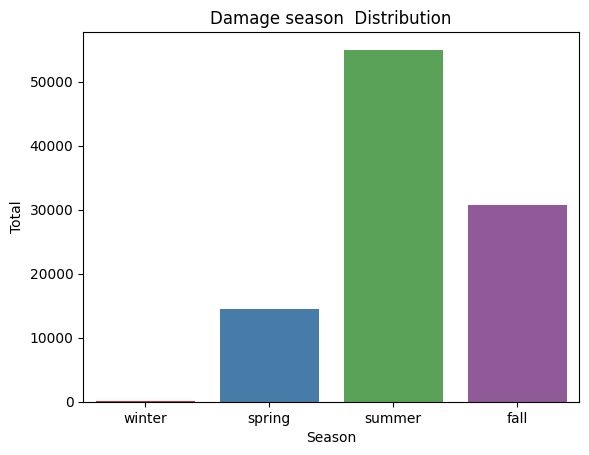

In [ ]:
inter = (0,4,7,10,13)
cats = ['winter','spring','summer', 'fall']
df['season'] = pd.cut(df.month, inter, labels = cats)

ax = sns.countplot(x = 'season',  data = df, palette = 'Set1')

ax.set(xlabel='Season', ylabel='Total',
       title="Damage season  Distribution")

plt.show()

##Separación y codificación de variables

Con el fin de aplicar un modelo clasificador de árboles, se separa la selecciones la varibale 'damage' como taget y el resto como predictoras. Se insta el modelo

In [ ]:
y=df.pop('damage')
X=df
print(X.shape)
X.head(10)

(100230, 8)


,fire_unit,hazard_type,structure_type,month,deck_material_ground,deck_elevated,patio_cover_carport,season
0,LNU,Fire,Residential,6,Combustible,Combustible,None,spring
1,LNU,Fire,Residential,6,No_Combustible,None,None,spring
2,LNU,Fire,Residential,6,None,None,None,spring
3,LNU,Fire,Residential,6,None,None,Combustible,spring
4,LNU,Fire,Residential,6,Combustible,Combustible,Combustible,spring
5,LNU,Fire,Residential,6,Combustible,Combustible,Combustible,spring
6,LNU,Fire,Residential,6,Combustible,Combustible,Combustible,spring
7,LNU,Fire,Infrastructure,6,Unknown,Unknown,Combustible,spring
8,LNU,Fire,Residential,6,Unknown,Unknown,Unknown,spring
9,LNU,Fire,Residential,6,Combustible,Combustible,Combustible,spring


In [ ]:
#Get dummies para variables categóricas nominales
X=pd.get_dummies(X, prefix_sep='-', dummy_na=False)
X.head(10)

,month,fire_unit-AEU,fire_unit-BDU,fire_unit-BEU,fire_unit-BTU,fire_unit-CZU,fire_unit-FKU,fire_unit-HUU,fire_unit-KRN,fire_unit-LAC,...,deck_elevated-None,deck_elevated-Unknown,patio_cover_carport-Combustible,patio_cover_carport-No_Combustible,patio_cover_carport-None,patio_cover_carport-Unknown,season-winter,season-spring,season-summer,season-fall
0,6,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
1,6,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,True,False,False
2,6,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,True,False,False
3,6,False,False,False,False,False,False,False,False,False,...,True,False,True,False,False,False,False,True,False,False
4,6,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
5,6,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
6,6,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
7,6,False,False,False,False,False,False,False,False,False,...,False,True,True,False,False,False,False,True,False,False
8,6,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,True,False,True,False,False
9,6,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False


In [ ]:
#Label Encoder para variables categóricas ordinales
le = LabelEncoder()
y = le.fit_transform(y)
print(y)

[5 0 5 ... 5 5 5]


In [ ]:
print('Tamaño X',X.shape)
print('Tamaño y',y.shape)

Tamaño X (100230, 53)
Tamaño y (100230,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 26, stratify=y)

In [ ]:
criterio = 'entropy'
arbol_clasificador = DecisionTreeClassifier(criterion=criterio, random_state=26)
arbol_clasificador.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=26)

/tmp/ipython-input-1322563200.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=arbol_clasificador.feature_importances_, y=X_train.columns, palette= 'viridis')


<Axes: ylabel='None'>

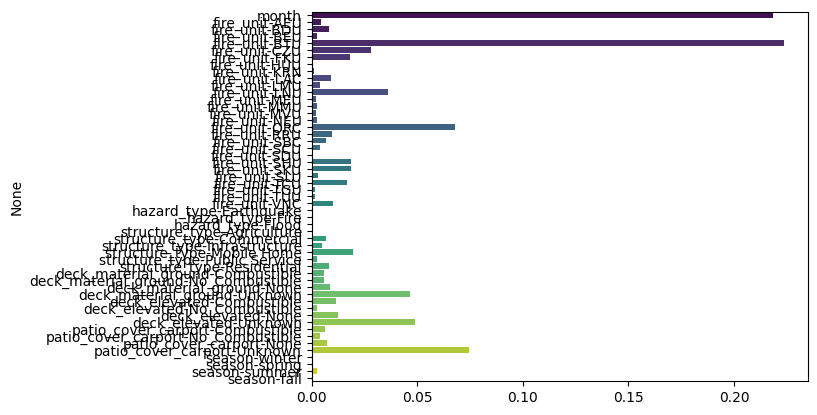

In [ ]:
sns.barplot(x=arbol_clasificador.feature_importances_, y=X_train.columns, palette= 'viridis')

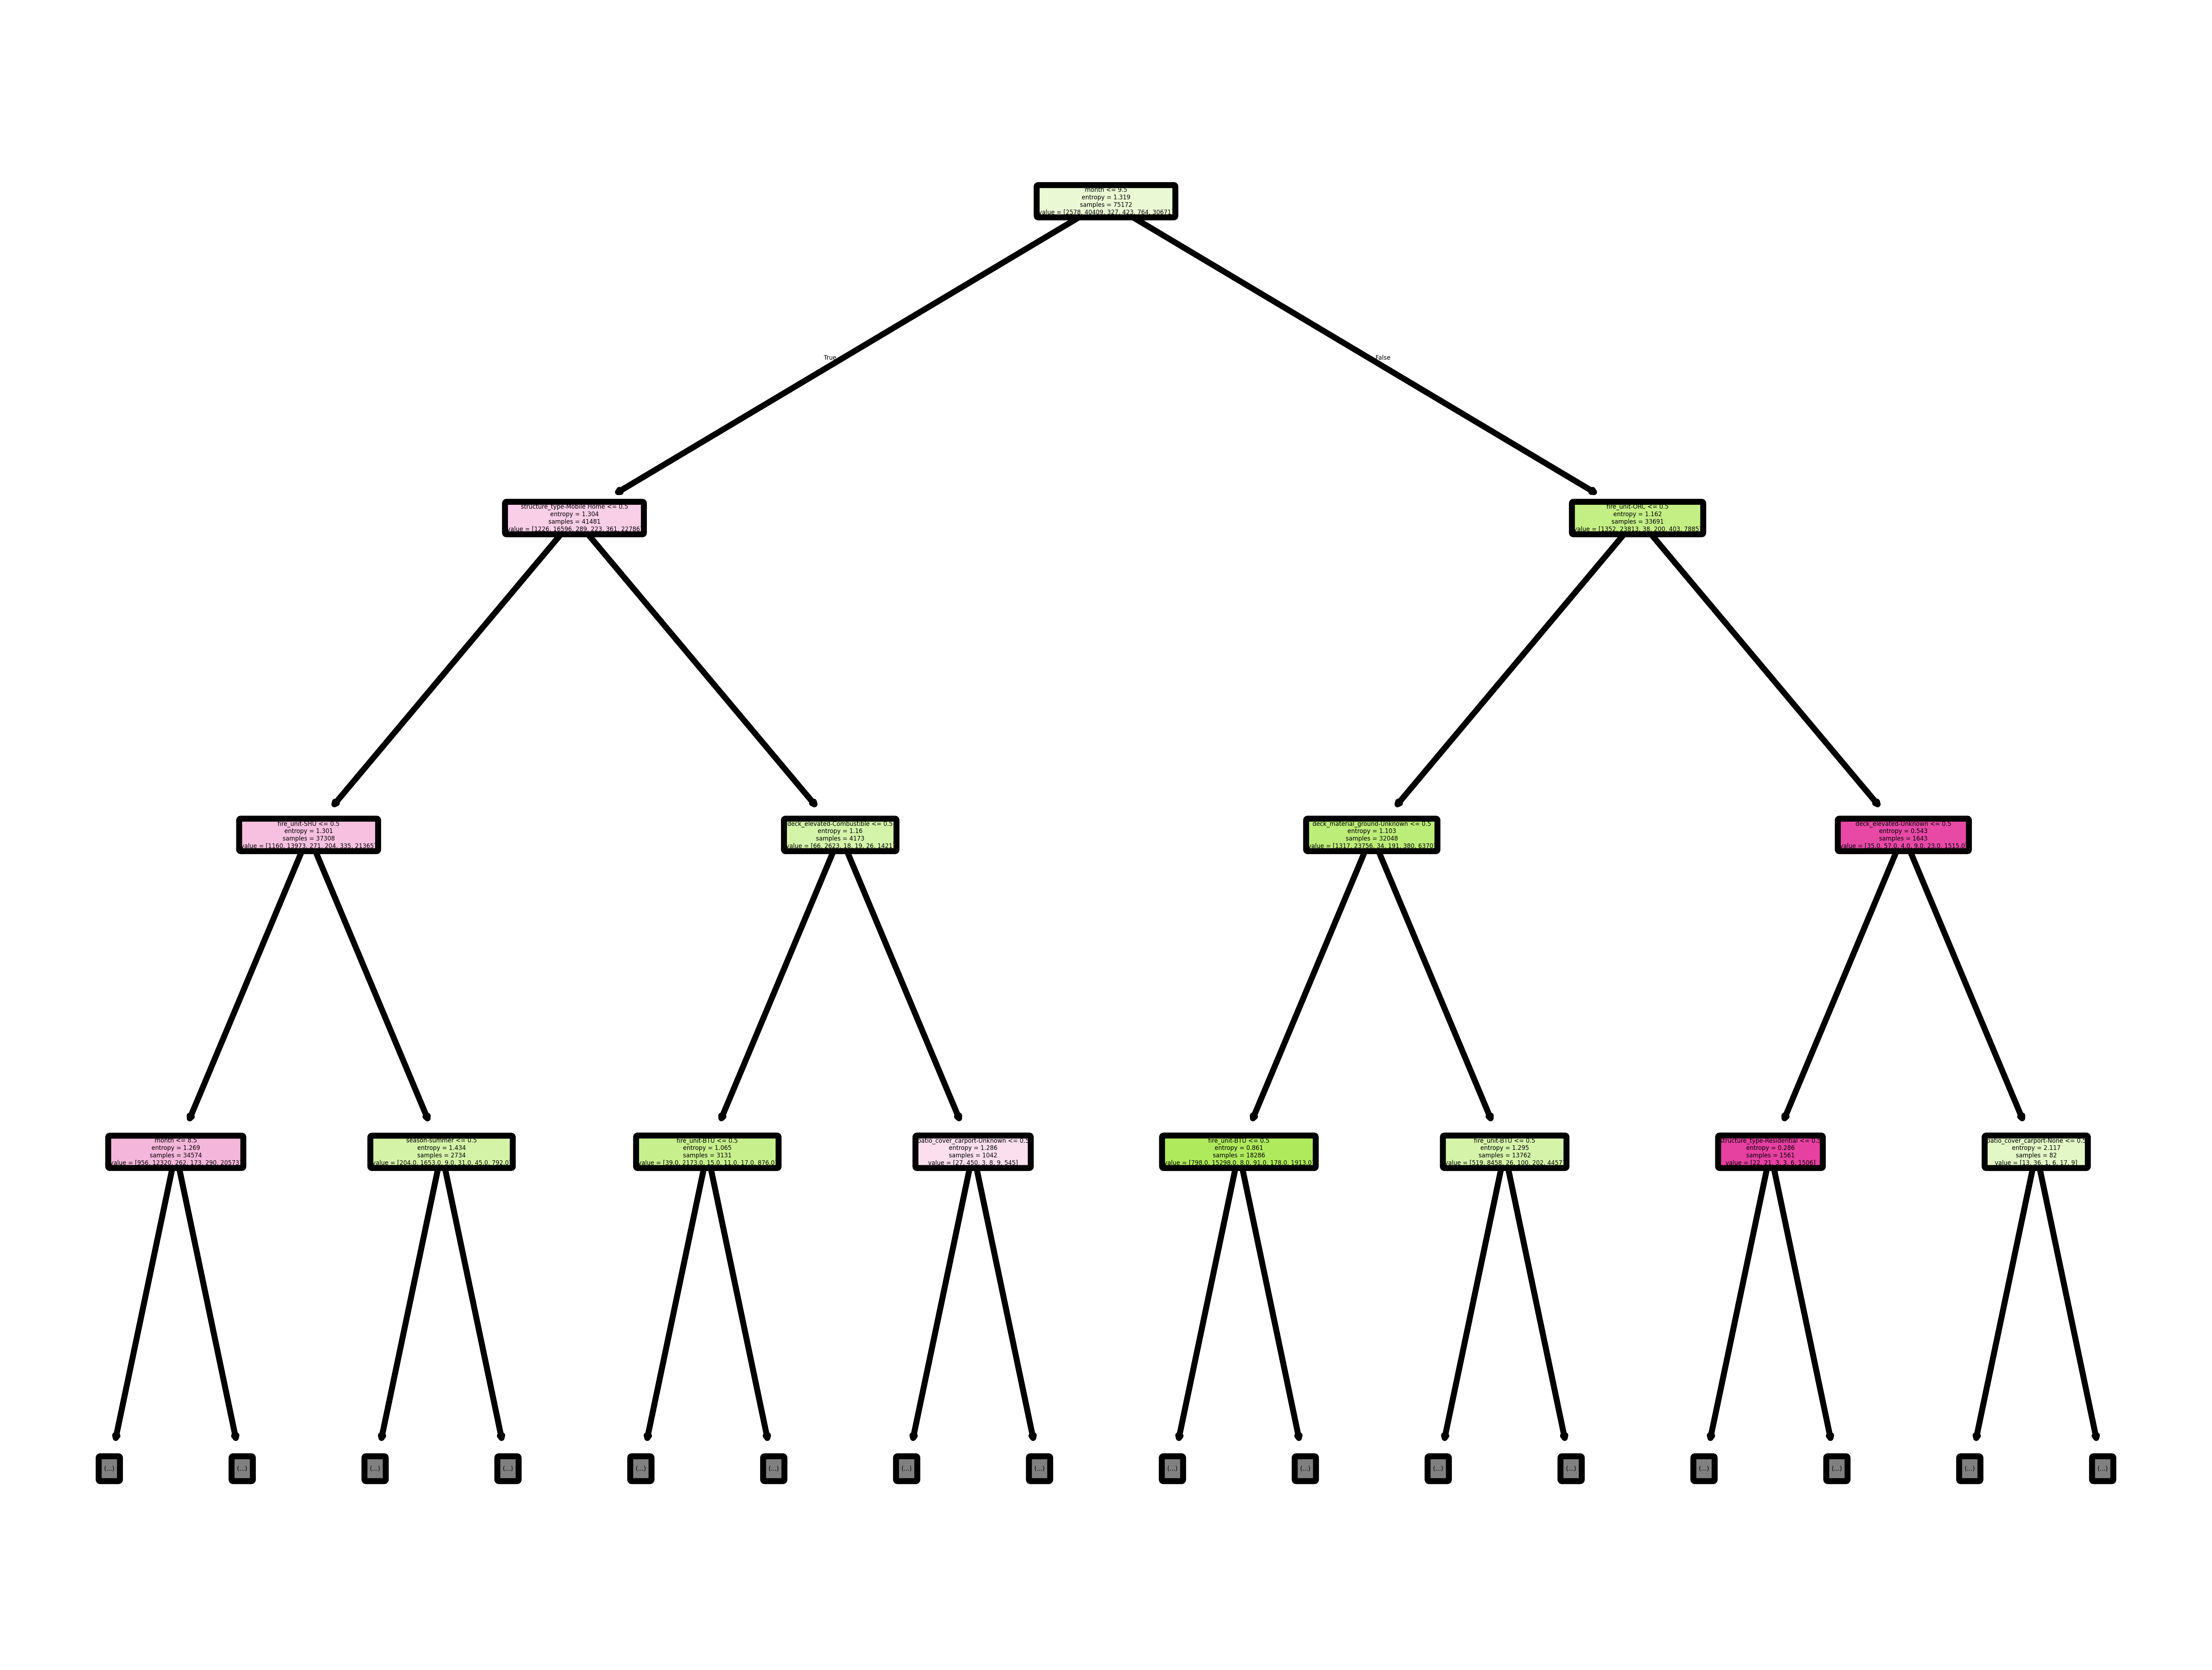

In [ ]:
#Ploteamos el árbol
list_features=list(X.columns)
plt.figure(dpi=1200)
plot_tree(arbol_clasificador, filled=True, rounded=True, feature_names=list_features, max_depth=3)
plt.show()
plt.close()

In [ ]:
y_pred = arbol_clasificador.predict(X_test)
print('Score train: ', arbol_clasificador.score(X_train, y_train))
print('Score test:  ', arbol_clasificador.score(X_test, y_test))

Score train:  0.8523386367264407
Score test:   0.8339452470268977


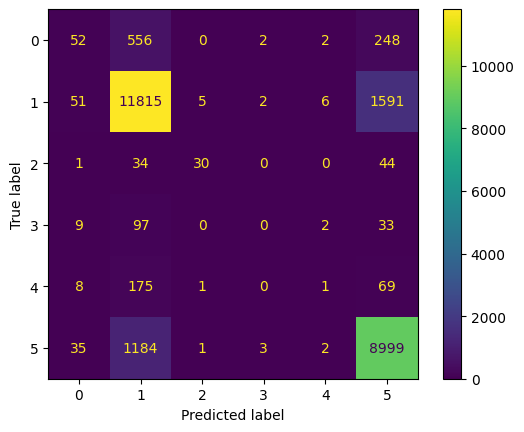

In [ ]:
matriz = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(matriz).plot()

## Conclusiones

El análisis exploratorio permitió identificar patrones temporales en la ocurrencia de incendios forestales, así como indicendcia en los materiales de construcción reportados en las edificaciones.
Estos resultados son consistentes con lo reportado en la literatura y destacan la utilidad del análisis exploratorio como paso inicial para el estudio de la dinámica de incendios forestales y el desarrollo de análisis más avanzados.